In [10]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx

class Region:
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def shift_by(self,dx,dy):
        self.x = self.x+dx
        self.y = self.y+dy
    def dis(self,r,dis_method='euclidean'):
        if dis_method=='manhattan':
            return abs(self.x-r.x)+abs(self.y-r.y)
        else:
            return ((self.x-r.x)**2+(self.y-r.y)**2)**0.5

class TimeInterval:
    def __init__(self,b,e):
        self.b = b
        self.e = e
        if(self.b>self.e):
            temp = self.b
            self.b = self.e
            self.e = temp
    def time_intersects(self,time):
        if self.b<=time and time<=self.e:
            return True
        return False

def calc_intention(fear,Q=30,v=0.08):
    return 1.0/(1.0+Q*math.exp(-v*fear))

class Agent:
    def __init__(self, idx, r, beta):
        self.id = idx
        self.region = r
        self.beta = beta #(flee bias beta between [0,1])
        self.fear = 0 #(>0)
        self.intention = calc_intention(self.fear)
        self.migration = 0
        self.migration_time = -1
        self.neighbor_history = []
        
    def update_fear(self,risk,theta=0):
        if self.migration!=1:
            self.fear = self.fear*theta + risk #(theta - discount [0,1])
            self.intention = calc_intention(self.fear)
            self.migration = 0
        else:
            self.fear = 1000000
            self.intention = 1
            self.migration = 1
    
    def reset_agent(self):
        self.fear = 0
        self.intention = calc_intention(self.fear)
        self.migration = 0
        self.migration_time = -1
        self.neighbor_history = []

    def update_migration_from_peer(self,peer_effect,gamma,THRESH):
        tot_weight = gamma*peer_effect+(1-gamma)*self.fear
        if (tot_weight>=THRESH) or self.migration==1:
            self.migration = 1
            if self.migration_time==-1:
                self.migration_time = len(self.neighbor_history)
        else:
            self.migration = 0
            
    def __str__(self):
        all_info = ('agent id:',str(self.id),'current state:',str(self.migration),'loc:',str(self.region.x),',',str(self.region.y))
        return ' '.join(all_info)

class Event:
    def __init__(self, idx, r, w, tint):
        self.event_id = idx
        self.region = r
        self.weight = w
        self.interval = tint
    def happened(self,time):
        if (self.interval).time_intersects(time):
            return True
        return False
    def __str__(self):
        all_info = ('event id:',str(self.event_id),'weight:',str(self.weight),'loc:',str(self.region.x),',',str(self.region.y),'time interval: from',str(self.interval.b),'to',str(self.interval.e))
        return ' '.join(all_info)

def riskfunc(a,E,alpha):
    tot = 0.0
    for event in E:
        #dis = ((a.region).dis(event.region,dis_method='euclidean'))**delta
        dis = np.exp(-(alpha*(a.region).dis(event.region,dis_method='euclidean')))
        #dis = dis+EPS
        cur_fear = (a.beta)*(event.weight)*dis
        tot = tot+cur_fear
    return tot
            

def createplot(Agents,Events,ax,Zoom_Factor=2,Agent_Size=5):
    OFFSET = 0.1
    for a in Agents:
        ax.plot(a.region.x,a.region.y,marker='o',color='blue',markersize=Agent_Size)
    for e in Events:
        ax.plot(e.region.x,e.region.y,marker='X',color='red',markersize=int(e.weight)*Zoom_Factor)
        #ax.annotate(str(e.event_id), xy =(e.region.x,e.region.y), 
        #     xytext =(e.region.x+OFFSET, e.region.y+OFFSET))
    ax.set_xlim([0,MAX_SCALE])
    ax.set_ylim([0,MAX_SCALE])
    
def create_neighbor_plot(Agents,G,ax,Agent_Size=5):
    for a in Agents:
        for b in Agents:
            if a.id in G.neighbors(b.id):
                ax.plot([a.region.x,b.region.x],[a.region.y,b.region.y],linestyle='--',linewidth=0.5,alpha=0.2,color='black')    

In [11]:
def create_discrete_poisson_process(rate, radius, time_horizon, delta_t=1):
    event_times = np.arange(0, time_horizon, delta_t)
    num_events = np.random.poisson(rate * delta_t, len(event_times))
    all_events = []
    event_id = 0
    for tidx,t in enumerate(event_times):
        event_at_t = num_events[tidx]
        #print(event_at_t)
        for e in range(event_at_t):
            angle = np.random.uniform(0, 2 * np.pi)  # Angle uniformly from [0, 2*pi]
            radial_distance = radius * np.sqrt(np.random.uniform(0, 1))  # Radial distance uniformly within the circle
            # Convert polar coordinates to Cartesian coordinates
            x = radial_distance * np.cos(angle)
            y = radial_distance * np.sin(angle)
            reg = Region(x,y)
            tint = TimeInterval(t,t)
            all_events.append(Event(event_id,reg,1,tint))
            event_id = event_id + 1
    return all_events

def create_random_agents(NUM_AGENTS):
    RANDOM_AGENTS = []
    for i in range(0,NUM_AGENTS):
        cur_id = i
        rand_loc = np.random.rand(1,2).flatten()
        agent_rand_loc = np.random.rand(1,2).flatten()
        agent_r = Region(agent_rand_loc[0]*MAX_SCALE,agent_rand_loc[1]*MAX_SCALE)
        john = Agent(cur_id, agent_r,1)
        RANDOM_AGENTS.append(john)
    return RANDOM_AGENTS


In [65]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx
graph_type = 'WS'
all_results_df = [pd.read_csv(f'Poisson_simulation_results/{f}') for f in os.listdir('Poisson_simulation_results/') if f.startswith( f'poisson_{graph_type}')]
result_df = pd.concat(all_results_df)

In [66]:
def calc_exp_frac(a,r,tau,gamma,rate,deg):
    ar = a*r
    frac_1_nom = (ar**2)*tau - 2*(1-gamma)*rate*(1-np.exp(-ar)*(1+ar))
    return max(0,min(1,frac_1_nom/((ar**2)*gamma*deg)))

def calc_exp_frac_2(a,r,tau,gamma,rate,deg):
    frac_nom = tau - 2*(1-gamma)*rate
    return max(0,min(1,frac_nom/(gamma*deg)))

def adjust_legend(ax,lgd_params):
    #LEGEND_PARAMS = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':2,'ecolor':'black','size':12,'alpha':0.2}
    ax.legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
                  handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
                  ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, prop={'size': lgd_params['size']})
    
def evaluate_results(agents,G,alpha,radius,tau,gamma,rate):
    DEL = 0
    degree_dict = dict()
    for aidx, a in enumerate(agents):
        degree_dict[G.degree[aidx]] = [0,0]
    we = 0
    they = 0
    tot = 0
    sq_error_our = 0
    sq_error_naive = 0
    for aidx,a in enumerate(agents):
        if (G.degree[aidx]>0):
            if a.migration_time==-1:
                continue
            theory_val = calc_exp_frac(alpha,radius,tau,gamma,rate,G.degree[aidx])
            fraction_then = a.neighbor_history[a.migration_time+DEL]
            #print('agent ',aidx,'migrated at time',a.migration_time+DEL,'neighbors migrated then was',
                  #round(fraction_then,2),'diff of',round(abs(fraction_then-theory_val),2),'with our derivation and diff of',round(abs(tau/(G.degree[aidx])-fraction_then),2)
                  #,'with naive derivation',end='--')
            sq_error_our = sq_error_our + (fraction_then-theory_val)*(fraction_then-theory_val)
            sq_error_naive = sq_error_naive + (min(1,tau/(G.degree[aidx]))-fraction_then)*(min(1,tau/(G.degree[aidx]))-fraction_then)
            better_est = 'our' if round(abs(fraction_then-theory_val),2)<round(abs(min(1,tau/(G.degree[aidx]))-fraction_then),2) else 'naive'
            tot = tot + 1
            if better_est=='our':
                we = we+1
                degree_dict[G.degree[aidx]][0] = degree_dict[G.degree[aidx]][0] + 1 
            else:
                they = they+1
                degree_dict[G.degree[aidx]][1] = degree_dict[G.degree[aidx]][1] + 1 
            #print(better_est,'method better')
            #adjust_legend(ax[aidx//A_C][aidx%A_C],LEGEND_PARAMS)
    if tot==0:
        return 0.5,-1,-1
    return we/tot,(sq_error_our/tot)**0.5,(sq_error_naive/tot)**0.5

In [57]:
# seed_df = result_df.groupby(['gamma','rate'])['seed'].count().reset_index()

In [58]:
# seed_df

In [59]:
# seed_df[seed_df.seed==50]

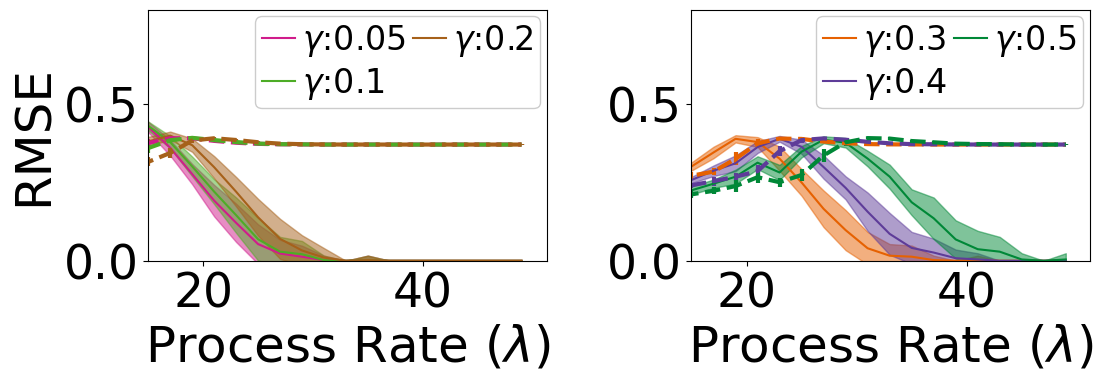

In [67]:
from matplotlib import rcParams

#rcParams["font.family"] = "calibri"
# rcParams["font.size"] = 44
# rcParams["axes.labelsize"] = 20
# rcParams["axes.titlesize"] = 20
# rcParams["xtick.labelsize"] = 18
# rcParams["ytick.labelsize"] = 18
max_font_size = 40
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-4
rcParams["axes.titlesize"] = max_font_size-2
rcParams["xtick.labelsize"] = max_font_size-6
rcParams["ytick.labelsize"] = max_font_size-6
MARK_EVERY=2
#colorlist = ['#e66101','#fdb863','#b2abd2','#5e3c99']['#7b3294','#c2a5cf','#a6dba0','#008837']
#['#d01c8b','#f1b6da','#b8e186','#4dac26']['#a6611a','#dfc27d','#80cdc1','#018571']

colorlist_mid = ['#e66101','#5e3c99','#008837','#7b3294']
colorlist_lo = ['#d01c8b','#4dac26','#a6611a','#018571']
markerlist = ['x','+','^','o']
markerlist = [None,None,None,None]

LEGEND_PARAMS = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,
                 'cspace':0.2,'ncol':2,
                 'ecolor':'black','size':24,'alpha':0.2}

fig,ax = plt.subplots(1,2,figsize=(12,5))

lo = 0.0
hi = 0.2
relevant_df = result_df[(result_df.gamma>lo) & (result_df.gamma<=hi) & (result_df.mse_our>-1)]
relevant_df_mean = relevant_df.groupby(['gamma','rate'])[['acc','mse_our','mse_naive']].mean().reset_index()
relevant_df_std = relevant_df.groupby(['gamma','rate'])[['acc','mse_our','mse_naive']].std().reset_index()

for gidx, gamma in enumerate(relevant_df_mean['gamma'].unique().tolist()):
    cur_df_mean = relevant_df_mean[relevant_df_mean.gamma==gamma]
    cur_df_std = relevant_df_std[relevant_df_std.gamma==gamma]
    cur_df_mean = cur_df_mean.sort_values(by='rate')
    cur_df_std = cur_df_std.sort_values(by='rate')
    xs = cur_df_mean['rate']
    ys1 = cur_df_mean['mse_our']
    ys1_error = cur_df_std['mse_our']*1
    ys2 = cur_df_mean['mse_naive']
    ys2_error = cur_df_std['mse_naive']
    #p=ax[0].plot(xs,ys1,label='$\\gamma$:'+str(gamma),marker=markerlist[gidx],
    #             markevery=MARK_EVERY,color=colorlist_lo[gidx])
    #ax[0].errorbar(xs,ys1,yerr=ys1_error,label='$\\gamma$:'+str(gamma),marker=markerlist[gidx],
    #             markevery=MARK_EVERY,color=colorlist_lo[gidx])
    ax[0].plot(xs,ys1,color=colorlist_lo[gidx],alpha=1,label='$\\gamma$:'+str(gamma))
    ax[0].fill_between(xs,ys1-ys1_error,ys1+ys1_error,color=colorlist_lo[gidx],alpha=0.5)
    #ax[0].p[-1].get_color()
    ax[0].errorbar(xs,ys2,yerr=ys2_error,color=colorlist_lo[gidx],marker=markerlist[gidx],linewidth=3,linestyle='--',
               markevery=MARK_EVERY,alpha=1)
    
lo = 0.2
hi = 0.5
relevant_df = result_df[(result_df.gamma>lo) & (result_df.gamma<=hi) & (result_df.mse_our>-1)]
relevant_df_mean = relevant_df.groupby(['gamma','rate'])[['acc','mse_our','mse_naive']].mean().reset_index()
relevant_df_std = relevant_df.groupby(['gamma','rate'])[['acc','mse_our','mse_naive']].std().reset_index()

for gidx, gamma in enumerate(relevant_df_mean['gamma'].unique().tolist()):
    cur_df_mean = relevant_df_mean[relevant_df_mean.gamma==gamma]
    cur_df_std = relevant_df_std[relevant_df_std.gamma==gamma]
    cur_df_mean = cur_df_mean.sort_values(by='rate')
    cur_df_std = cur_df_std.sort_values(by='rate')
    xs = cur_df_mean['rate']
    ys1 = cur_df_mean['mse_our']
    ys1_error = cur_df_std['mse_our']*1
    ys2 = cur_df_mean['mse_naive']
    ys2_error = cur_df_std['mse_naive']
    #p=ax[0].plot(xs,ys1,label='$\\gamma$:'+str(gamma),marker=markerlist[gidx],
    #             markevery=MARK_EVERY,color=colorlist_mid[gidx])
    #ax[1].errorbar(xs,ys1,yerr=ys1_error,label='$\\gamma$:'+str(gamma),marker=markerlist[gidx],
                 #markevery=MARK_EVERY,color=colorlist_mid[gidx])
    ax[1].plot(xs,ys1,color=colorlist_mid[gidx],alpha=1,label='$\\gamma$:'+str(gamma))
    ax[1].fill_between(xs,ys1-ys1_error,ys1+ys1_error,color=colorlist_mid[gidx],alpha=0.5)
    #ax[0].p[-1].get_color()
    ax[1].errorbar(xs,ys2,yerr=ys2_error,color=colorlist_mid[gidx],marker=markerlist[gidx],linewidth=3,
               markevery=MARK_EVERY,linestyle='--',)

for i in range(0,2):
    adjust_legend(ax[i],LEGEND_PARAMS)
    ax[i].set_xlabel('Process Rate ($\\lambda$)')
    if i==0:
        ax[i].set_ylabel('RMSE')
    ax[i].set_ylim([0,0.8])
    ax[i].set_xlim([15,None])
    
fig.tight_layout()
fig.savefig(f'Figures/poisson_setting_neighbor_study_{graph_type}.pdf',dpi=350,bbox_inches='tight')

In [47]:
# relevant_df[(relevant_df.gamma==0.5) & (relevant_df.rate==13)]

<!-- Keep n fixed construct a curve
that shows for each different p, 
x axis t
y axis percentage of people migrating -->